In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/reanalysis/'

In [2]:
import xarray as xr
import numpy as np
# import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir)
from utils import split_e3sm, plot_results
from exp_hp import get_hp

2025-01-29 14:23:06.655200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 14:23:22.249894: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  1


### Fuctions

In [3]:
# ---------------- LEARNING RATE CALLBACK FUNCTION ----------------
# def scheduler(epoch, lr):
#     # This function keeps the initial learning rate for the first ten epochs
#     # and decreases it exponentially after that.
#     if epoch%10 != 0 or epoch == 0:
#         return lr
#     elif epoch%10 == 0 and epoch > 0:
#         return lr * tf.constant(.5,dtype=tf.float32)

In [4]:
def create_ann(input_shape, n_output, hiddens, RIDGE = 0, dropout = True, dropout_rate = 0.0):
    tf.keras.backend.clear_session() 

    # ----- input of cnn -----
    ann_input = keras.Input(shape = input_shape)

    for l,layer in enumerate(hiddens):
        # ----- ann layers -----
        if l == 0:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=RIDGE),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(ann_input)
            if dropout:
                x = layers.Dropout(rate = dropout_rate)(x)
        else:
            x = tf.keras.layers.Dense(layer, 
                                      activation = 'relu',
                                      use_bias = True, 
                                      kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                      bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                      kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
        
    # ----- output -----
    ann_output = tf.keras.layers.Dense(n_output,
                                       activation = tf.keras.activations.softmax,
                                       use_bias = True,
                                       kernel_regularizer = tf.keras.regularizers.l1_l2(l1=0.0, l2=0.0),
                                       bias_initializer = tf.keras.initializers.RandomNormal(seed=SEED),
                                       kernel_initializer = tf.keras.initializers.RandomNormal(seed=SEED)
                                      )(x)
    # ----- create unet -----
    ann = keras.Model(ann_input, ann_output, name = 'ann')
    
    return ann

### Load standardized E3SM

In [5]:
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)
print('Training Members: '+str(hps['train_mems']))
print('Validation Member: '+str(hps['val_mems'][0]))
print('Testing Member: '+str(hps['test_mems'][0]))
print('Lead: '+str(hps['LEAD']))
print('Region: '+str(hps['region'][0])+'N x '+str(hps['region'][1])+'E')

Training Members: ['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181']
Validation Member: 0191
Testing Member: 0301
Lead: 14
Region: 30-60N x 170-240E


In [6]:
%%time
Xtrain, Xval, _, Ytrain, Yval, _, _ = split_e3sm(trainmems = hps['train_mems'],
                                                      valmem = hps['val_mems'][0],
                                                      testmem = hps['test_mems'][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD']) # 330 or 210

CPU times: user 9.65 s, sys: 1.27 s, total: 10.9 s
Wall time: 12.6 s


In [7]:
Xval = Xval.reshape((Xval.shape[0],Xval.shape[1]*Xval.shape[2]))
Xtrain = Xtrain.reshape((Xtrain.shape[0],Xtrain.shape[1]*Xtrain.shape[2]))
input_shape = Xtrain.shape[1]

### Train NN

In [8]:
# ---------- ANN Hyperparameters ----------
NLABEL = 2
N_EPOCHS = 1000

HIDDENS = hps['HIDDENS']
BATCH_SIZE = hps['BATCH_SIZE']
LR_INIT = hps['LR_INIT']
RIDGE = hps['RIDGE']
dropout_rate = hps['DROPOUT_RATE']
PATIENCE = hps['PATIENCE']
GLOBAL_SEED = hps['GLOBAL_SEED']
dropout_bool = True

In [9]:
print(HIDDENS,
      BATCH_SIZE,
      LR_INIT,
      RIDGE,
      dropout_rate,
      PATIENCE)

[128] 256 0.0001 0.0 0.9 10


0


2025-01-29 14:24:00.559068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79191 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c1:00.0, compute capability: 8.0


Epoch 1/1000


2025-01-29 14:24:02.852329: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-01-29 14:24:03.784836: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x55cd55cf5e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-29 14:24:03.784881: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2025-01-29 14:24:03.848860: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-29 14:24:04.002764: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2025-01-29 14:24:04.282180: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

274/274 - 4s - loss: 1.2762 - sparse_categorical_accuracy: 0.5257 - val_loss: 0.6834 - val_sparse_categorical_accuracy: 0.5759 - 4s/epoch - 14ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.8938 - sparse_categorical_accuracy: 0.5378 - val_loss: 0.6635 - val_sparse_categorical_accuracy: 0.5794 - 625ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7416 - sparse_categorical_accuracy: 0.5479 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.5821 - 544ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.6917 - sparse_categorical_accuracy: 0.5621 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.5897 - 683ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6763 - sparse_categorical_accuracy: 0.5732 - val_loss: 0.6610 - val_sparse_categorical_accuracy: 0.5898 - 680ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6710 - sparse_categorical_accuracy: 0.5776 - val_loss: 0.6591 - val_sparse_categorical_accuracy: 0.5971 - 600ms/epoch - 2ms/step
Epoch 7/1000
274/274 - 1s

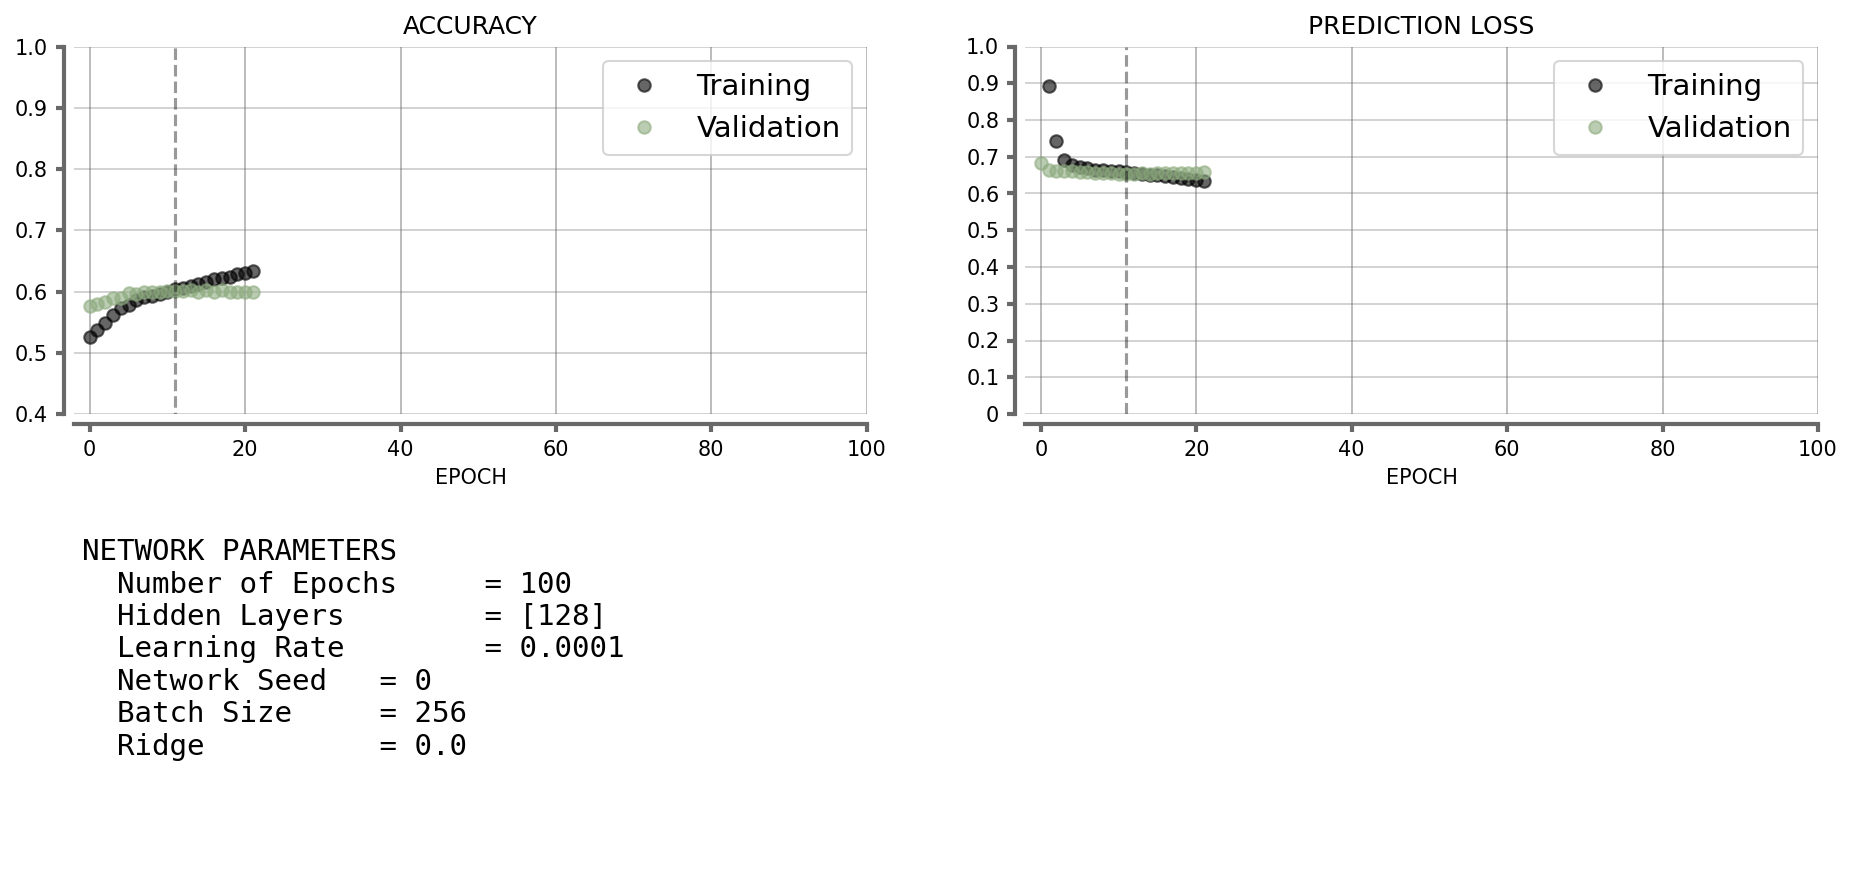

1
Epoch 1/1000
274/274 - 1s - loss: 1.3826 - sparse_categorical_accuracy: 0.5248 - val_loss: 0.7000 - val_sparse_categorical_accuracy: 0.5727 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.9567 - sparse_categorical_accuracy: 0.5399 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.5838 - 611ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7675 - sparse_categorical_accuracy: 0.5531 - val_loss: 0.6603 - val_sparse_categorical_accuracy: 0.5873 - 558ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.7075 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.6607 - val_sparse_categorical_accuracy: 0.5913 - 617ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6833 - sparse_categorical_accuracy: 0.5694 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.5999 - 612ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6730 - sparse_categorical_accuracy: 0.5778 - val_loss: 0.6584 - val_sparse_categorical_accuracy: 0.5997 - 562ms/epoch - 2ms/step
Epoch 7/100

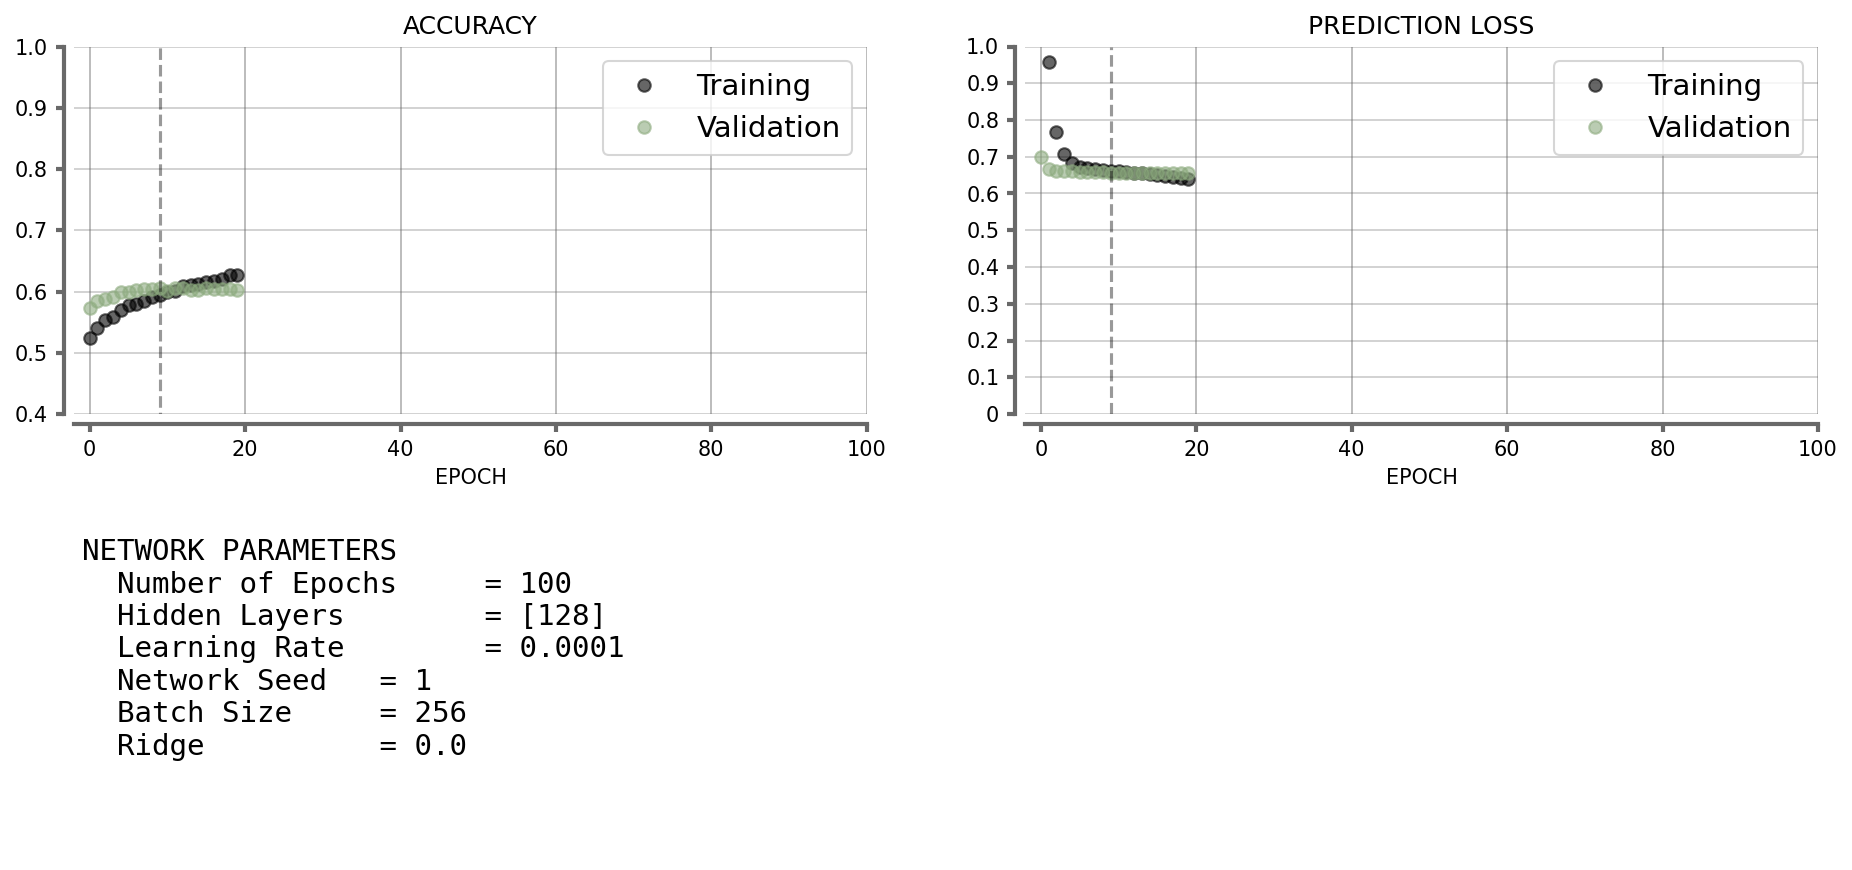

2
Epoch 1/1000
274/274 - 1s - loss: 1.3649 - sparse_categorical_accuracy: 0.5220 - val_loss: 0.6961 - val_sparse_categorical_accuracy: 0.5794 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.9435 - sparse_categorical_accuracy: 0.5356 - val_loss: 0.6664 - val_sparse_categorical_accuracy: 0.5859 - 632ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7548 - sparse_categorical_accuracy: 0.5457 - val_loss: 0.6629 - val_sparse_categorical_accuracy: 0.5929 - 656ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.6928 - sparse_categorical_accuracy: 0.5574 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.5943 - 628ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6753 - sparse_categorical_accuracy: 0.5711 - val_loss: 0.6612 - val_sparse_categorical_accuracy: 0.5931 - 563ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6712 - sparse_categorical_accuracy: 0.5778 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.5959 - 596ms/epoch - 2ms/step
Epoch 7/100

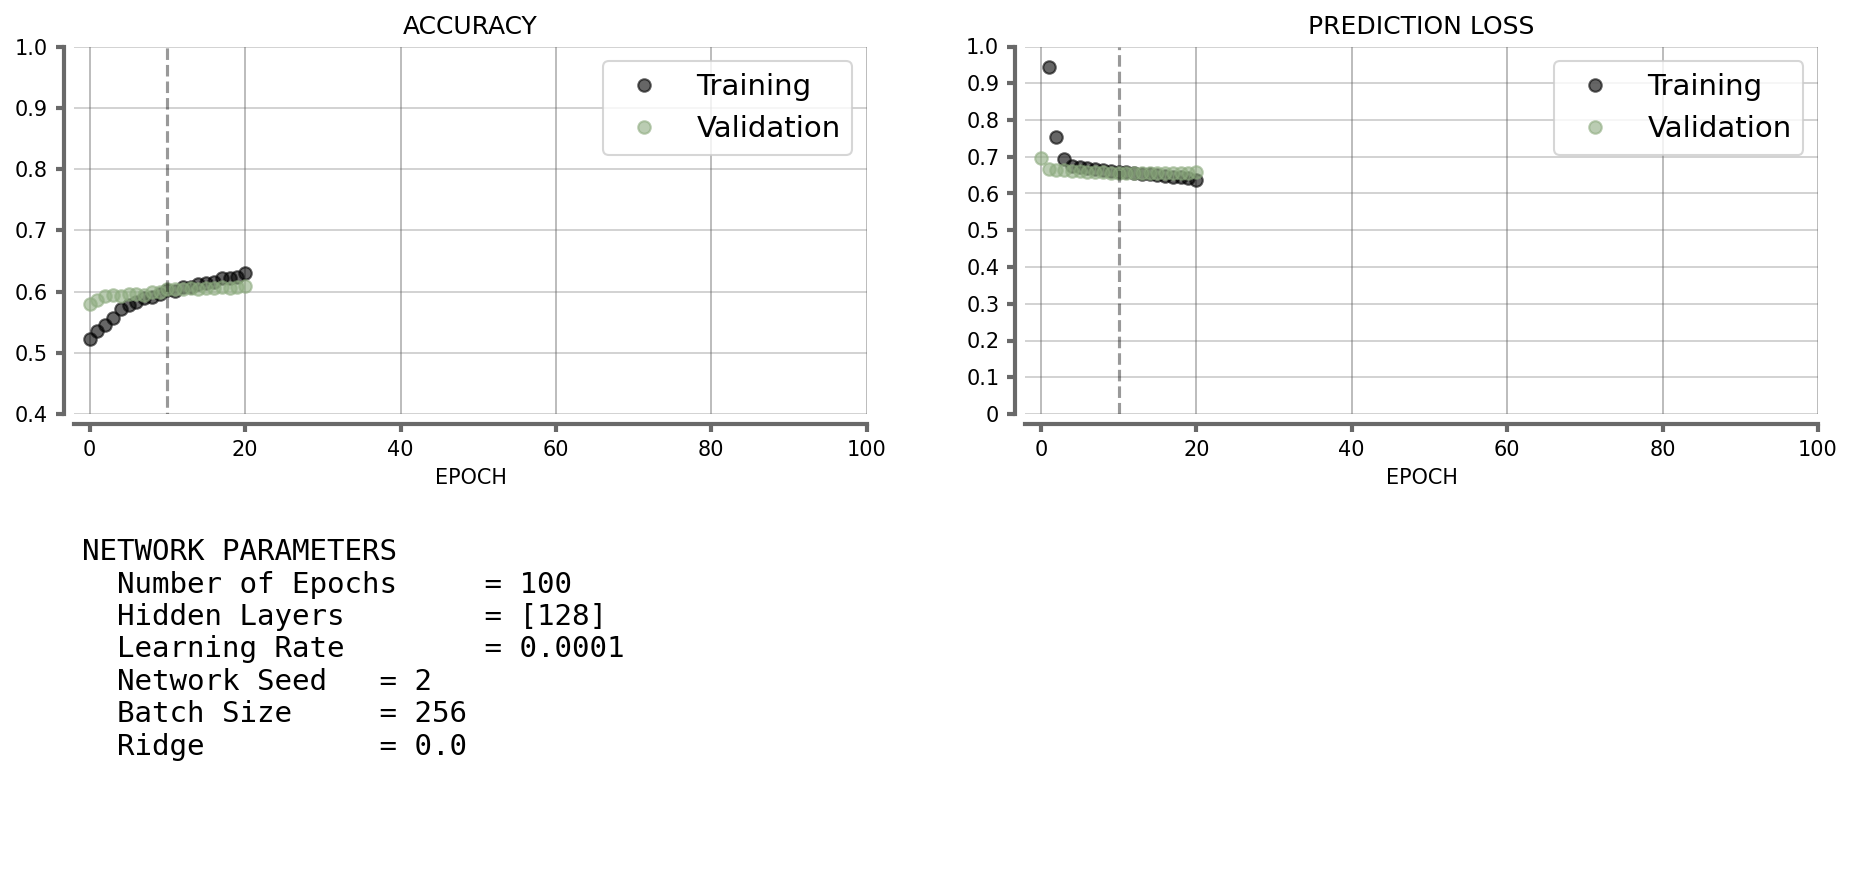

3
Epoch 1/1000
274/274 - 1s - loss: 1.4691 - sparse_categorical_accuracy: 0.5180 - val_loss: 0.6939 - val_sparse_categorical_accuracy: 0.5845 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 1.0002 - sparse_categorical_accuracy: 0.5340 - val_loss: 0.6634 - val_sparse_categorical_accuracy: 0.5923 - 606ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7943 - sparse_categorical_accuracy: 0.5442 - val_loss: 0.6589 - val_sparse_categorical_accuracy: 0.5963 - 670ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.7115 - sparse_categorical_accuracy: 0.5581 - val_loss: 0.6593 - val_sparse_categorical_accuracy: 0.6035 - 672ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6850 - sparse_categorical_accuracy: 0.5721 - val_loss: 0.6591 - val_sparse_categorical_accuracy: 0.6042 - 632ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6729 - sparse_categorical_accuracy: 0.5778 - val_loss: 0.6583 - val_sparse_categorical_accuracy: 0.6071 - 548ms/epoch - 2ms/step
Epoch 7/100

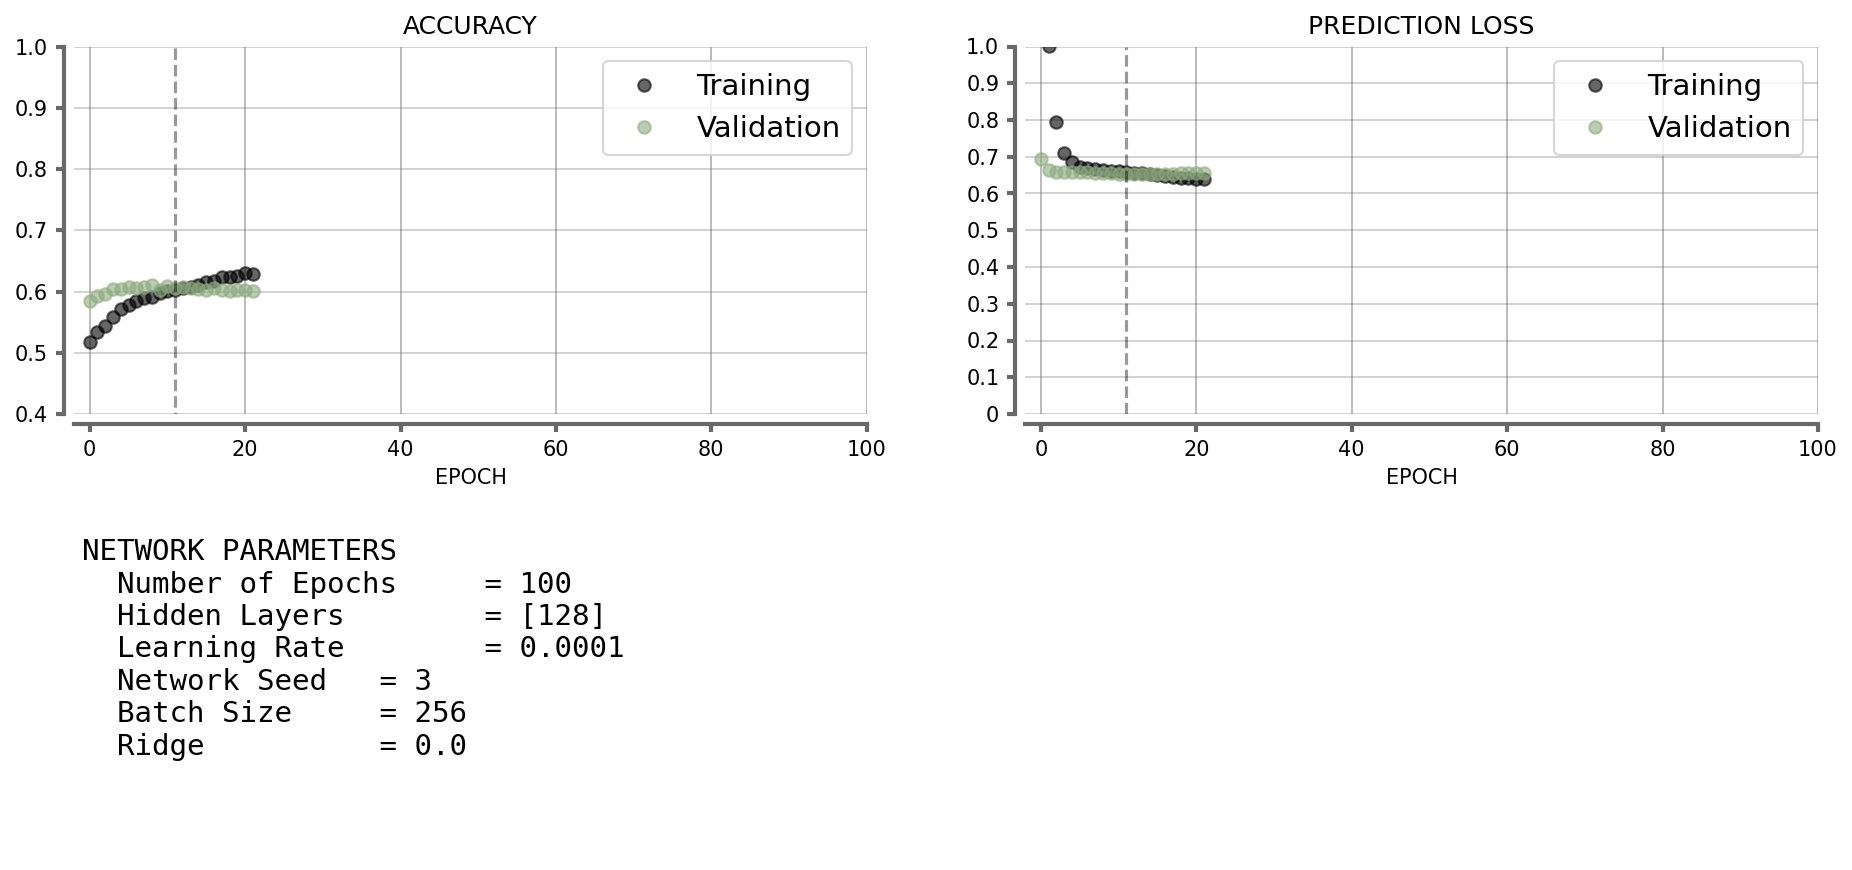

4
Epoch 1/1000
274/274 - 1s - loss: 1.3068 - sparse_categorical_accuracy: 0.5227 - val_loss: 0.6762 - val_sparse_categorical_accuracy: 0.5929 - 1s/epoch - 4ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.9097 - sparse_categorical_accuracy: 0.5372 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.5979 - 606ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7475 - sparse_categorical_accuracy: 0.5463 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.5990 - 607ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.6929 - sparse_categorical_accuracy: 0.5614 - val_loss: 0.6619 - val_sparse_categorical_accuracy: 0.5981 - 575ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6767 - sparse_categorical_accuracy: 0.5710 - val_loss: 0.6622 - val_sparse_categorical_accuracy: 0.6001 - 679ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6713 - sparse_categorical_accuracy: 0.5787 - val_loss: 0.6603 - val_sparse_categorical_accuracy: 0.6013 - 706ms/epoch - 3ms/step
Epoch 7/100

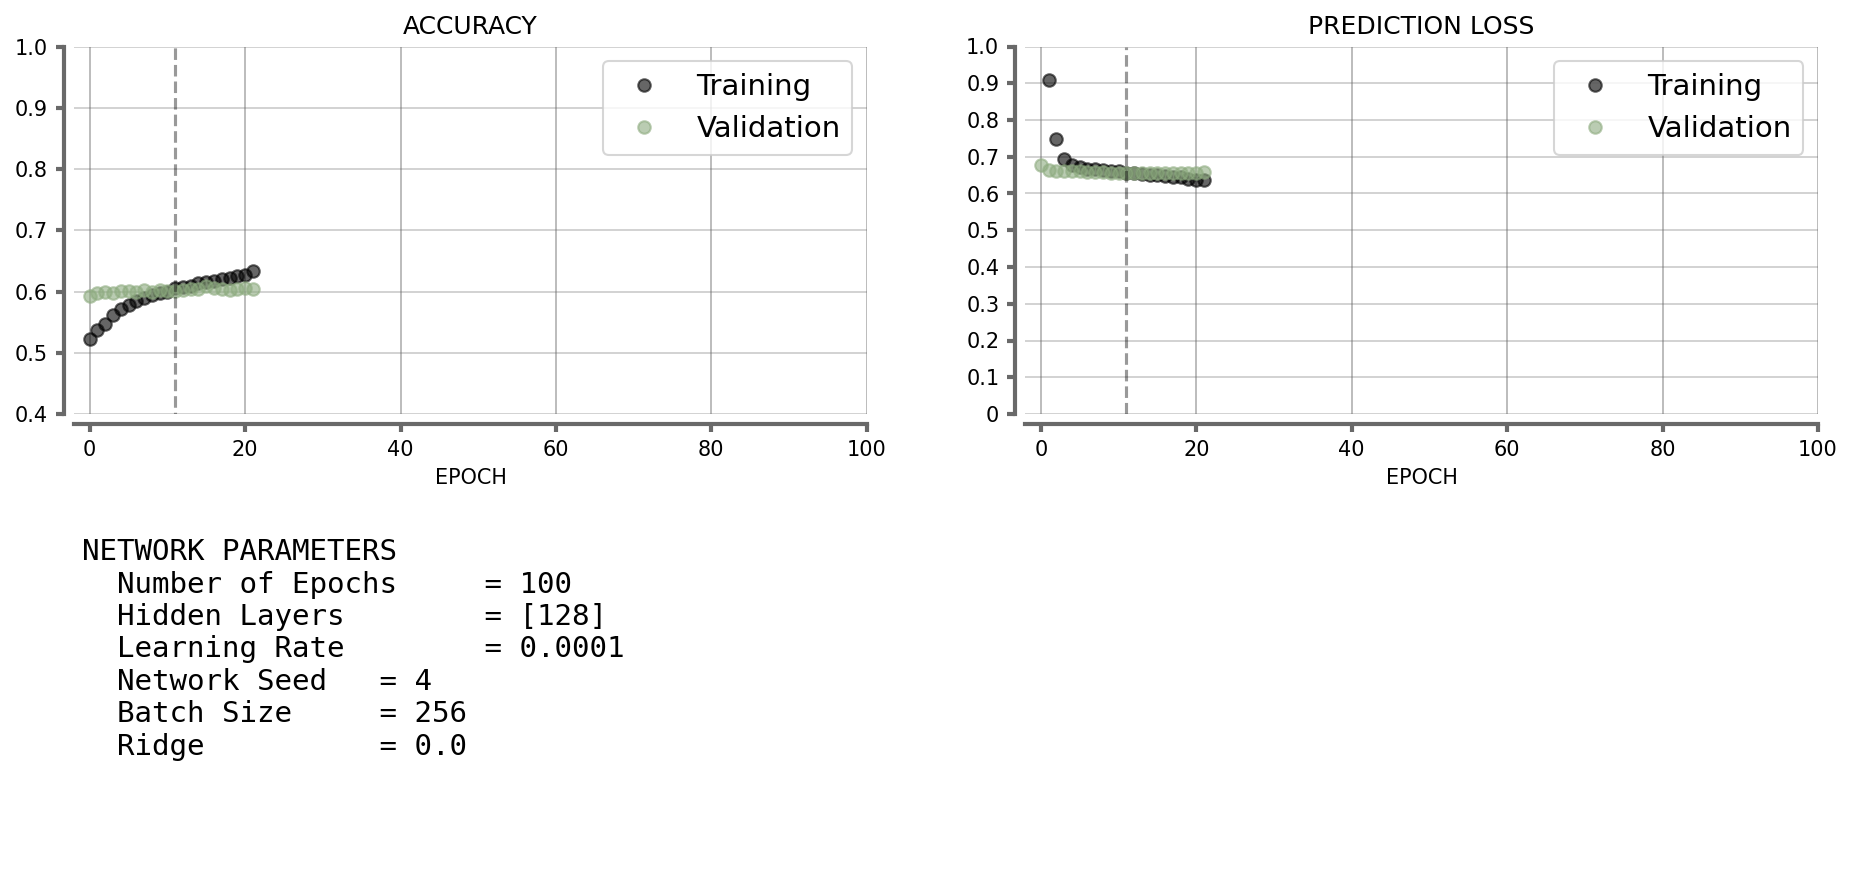

5
Epoch 1/1000
274/274 - 1s - loss: 1.2495 - sparse_categorical_accuracy: 0.5227 - val_loss: 0.6838 - val_sparse_categorical_accuracy: 0.5777 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.8752 - sparse_categorical_accuracy: 0.5418 - val_loss: 0.6625 - val_sparse_categorical_accuracy: 0.5879 - 627ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7327 - sparse_categorical_accuracy: 0.5505 - val_loss: 0.6616 - val_sparse_categorical_accuracy: 0.5947 - 556ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.6851 - sparse_categorical_accuracy: 0.5682 - val_loss: 0.6606 - val_sparse_categorical_accuracy: 0.5970 - 611ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6743 - sparse_categorical_accuracy: 0.5728 - val_loss: 0.6599 - val_sparse_categorical_accuracy: 0.5978 - 606ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6703 - sparse_categorical_accuracy: 0.5795 - val_loss: 0.6594 - val_sparse_categorical_accuracy: 0.5987 - 552ms/epoch - 2ms/step
Epoch 7/100

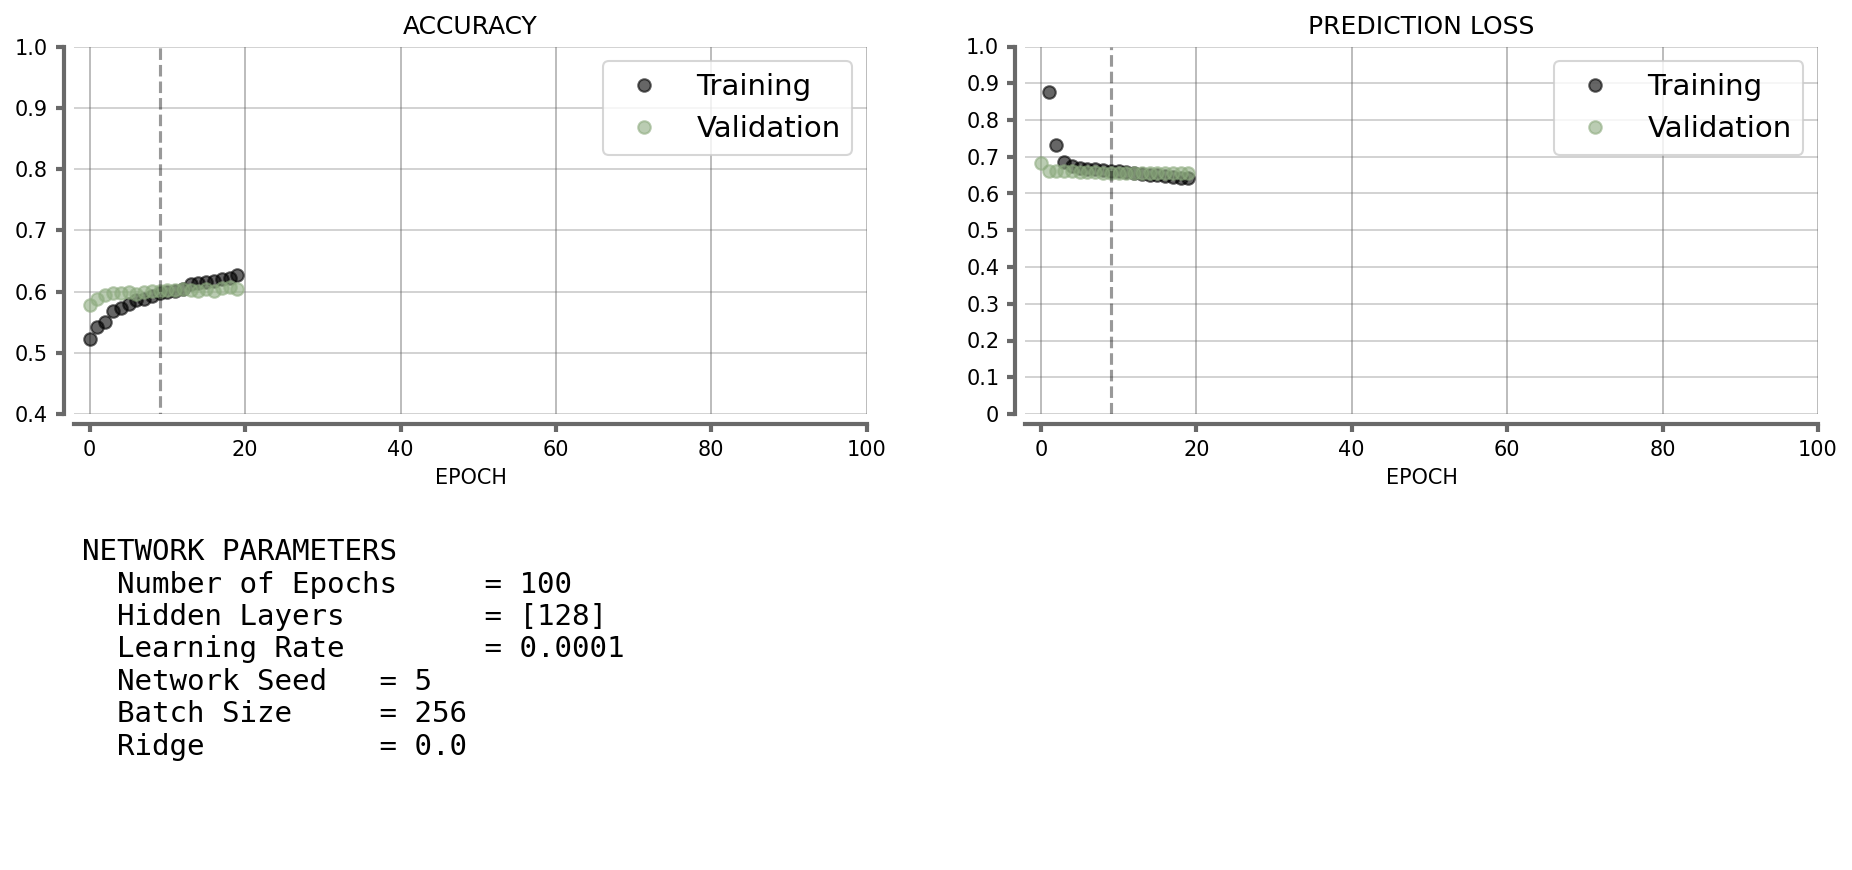

6
Epoch 1/1000
274/274 - 1s - loss: 1.3555 - sparse_categorical_accuracy: 0.5212 - val_loss: 0.7100 - val_sparse_categorical_accuracy: 0.5586 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.9308 - sparse_categorical_accuracy: 0.5389 - val_loss: 0.6742 - val_sparse_categorical_accuracy: 0.5647 - 569ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7474 - sparse_categorical_accuracy: 0.5500 - val_loss: 0.6674 - val_sparse_categorical_accuracy: 0.5811 - 684ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.6888 - sparse_categorical_accuracy: 0.5645 - val_loss: 0.6665 - val_sparse_categorical_accuracy: 0.5882 - 578ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6767 - sparse_categorical_accuracy: 0.5715 - val_loss: 0.6654 - val_sparse_categorical_accuracy: 0.5918 - 606ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6715 - sparse_categorical_accuracy: 0.5783 - val_loss: 0.6633 - val_sparse_categorical_accuracy: 0.5961 - 608ms/epoch - 2ms/step
Epoch 7/100

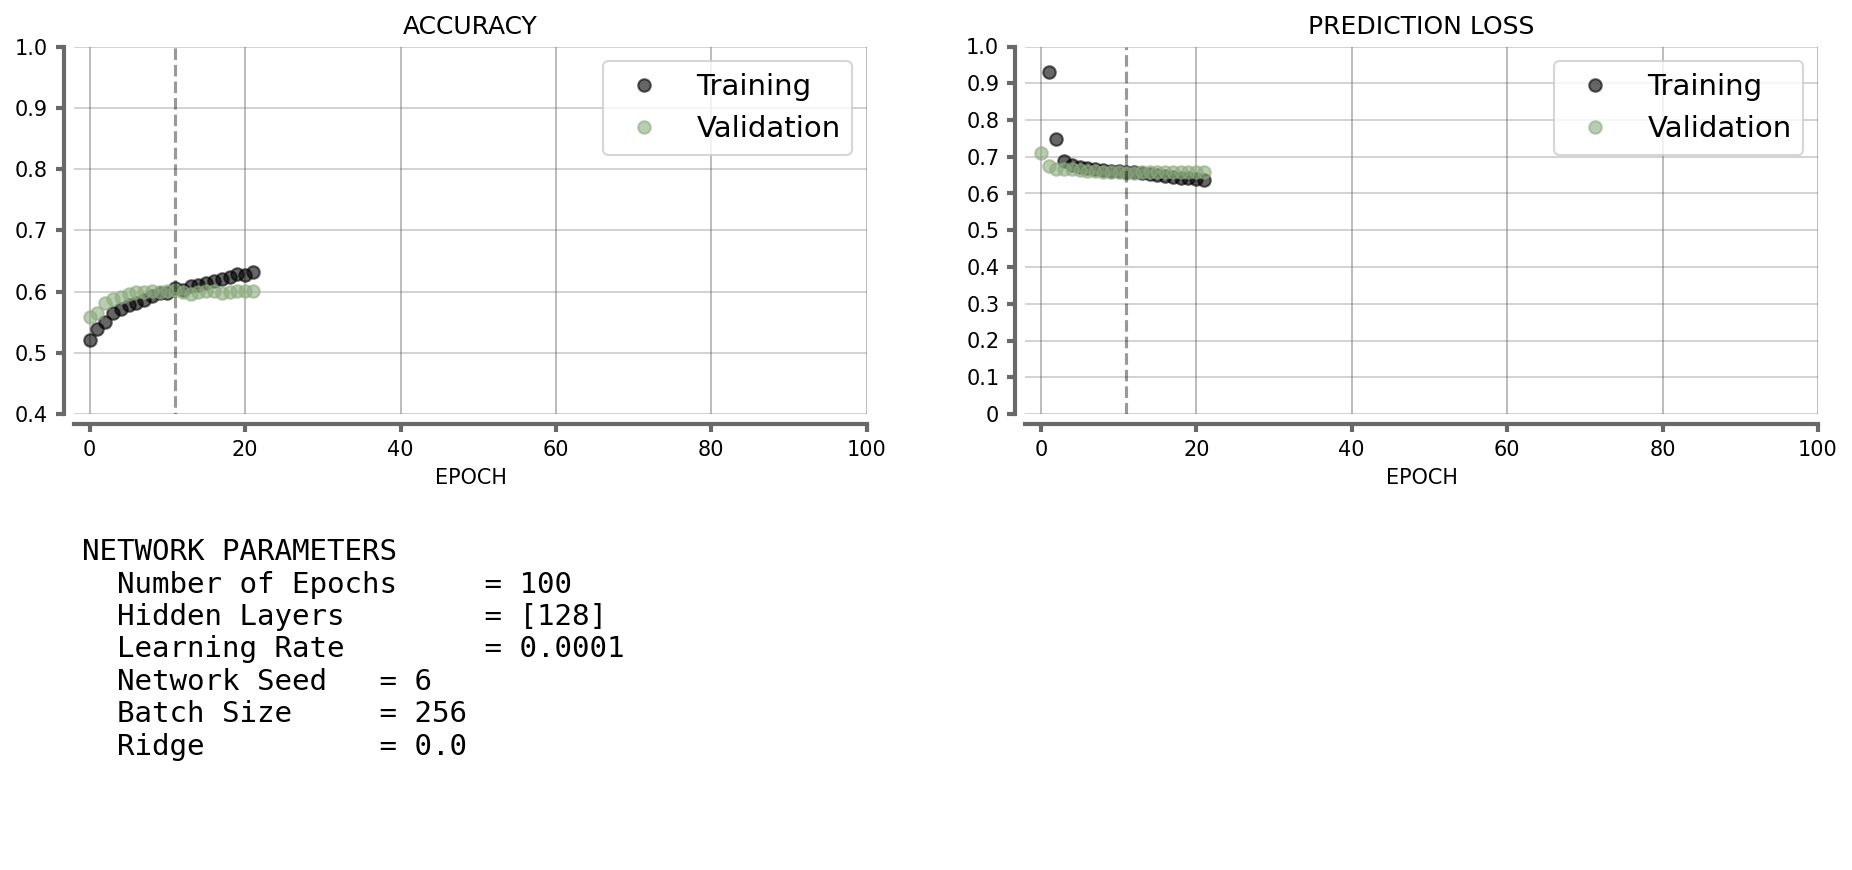

7
Epoch 1/1000
274/274 - 1s - loss: 1.3942 - sparse_categorical_accuracy: 0.5228 - val_loss: 0.7032 - val_sparse_categorical_accuracy: 0.5671 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.9460 - sparse_categorical_accuracy: 0.5416 - val_loss: 0.6701 - val_sparse_categorical_accuracy: 0.5787 - 611ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7584 - sparse_categorical_accuracy: 0.5468 - val_loss: 0.6639 - val_sparse_categorical_accuracy: 0.5917 - 559ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.6922 - sparse_categorical_accuracy: 0.5617 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.5939 - 610ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6766 - sparse_categorical_accuracy: 0.5721 - val_loss: 0.6626 - val_sparse_categorical_accuracy: 0.5973 - 557ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6713 - sparse_categorical_accuracy: 0.5798 - val_loss: 0.6617 - val_sparse_categorical_accuracy: 0.5967 - 570ms/epoch - 2ms/step
Epoch 7/100

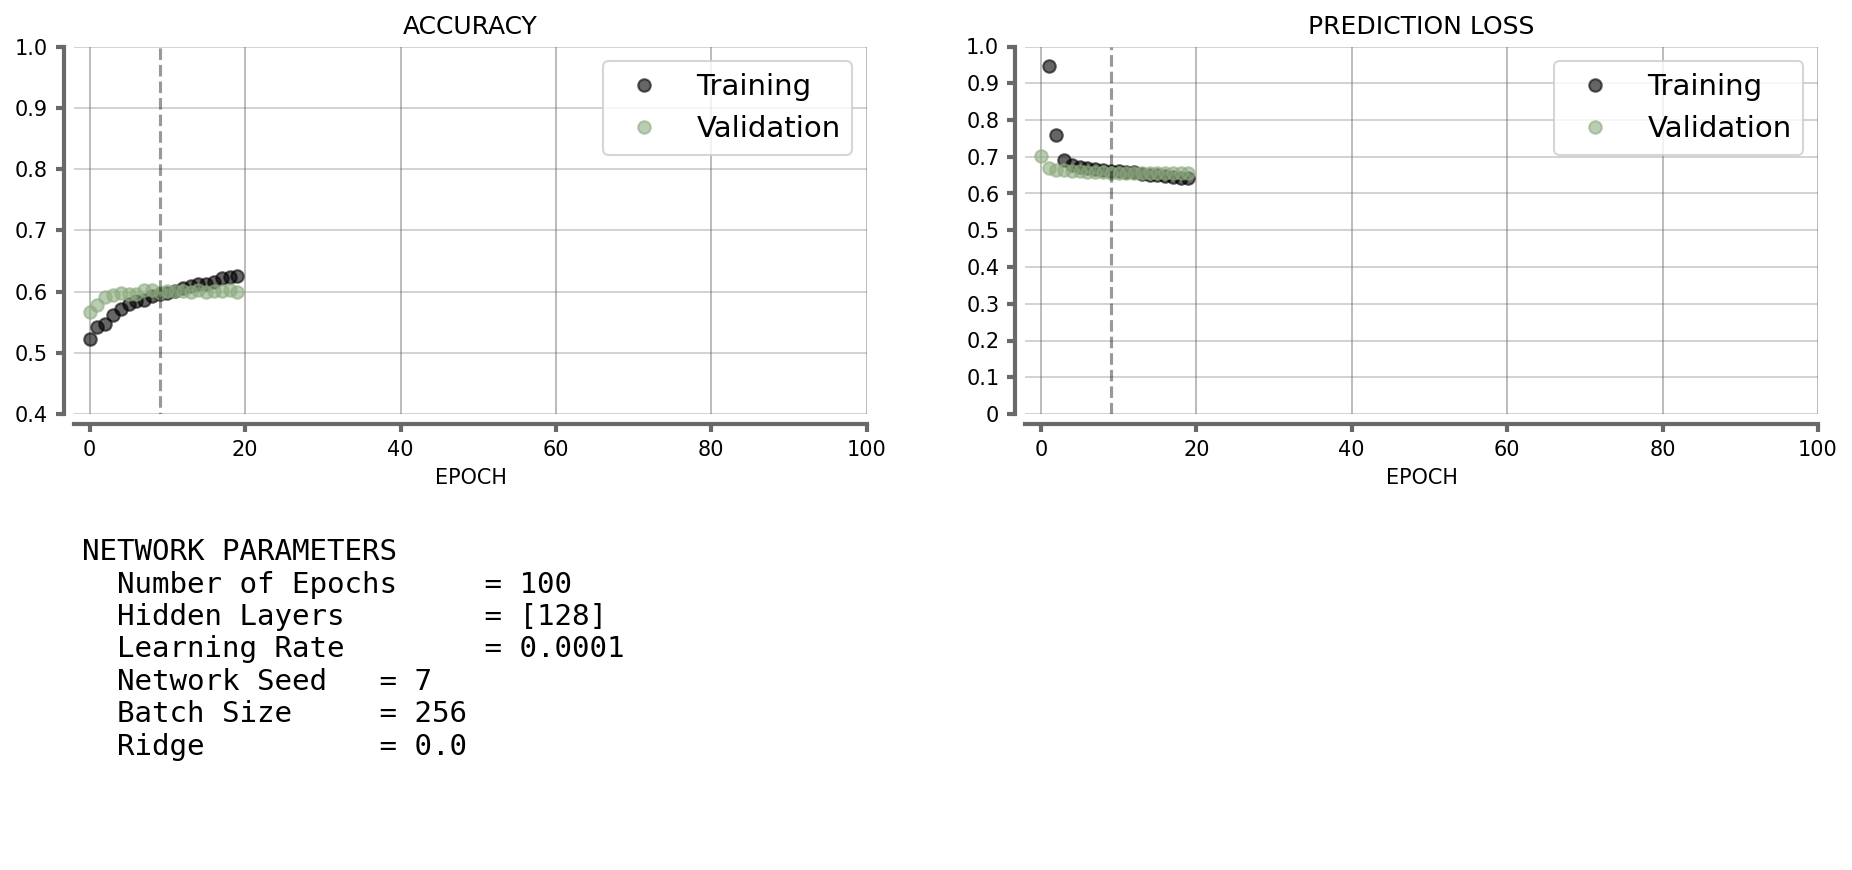

8
Epoch 1/1000
274/274 - 1s - loss: 1.4085 - sparse_categorical_accuracy: 0.5155 - val_loss: 0.6970 - val_sparse_categorical_accuracy: 0.5750 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 0.9585 - sparse_categorical_accuracy: 0.5377 - val_loss: 0.6691 - val_sparse_categorical_accuracy: 0.5826 - 541ms/epoch - 2ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.7716 - sparse_categorical_accuracy: 0.5492 - val_loss: 0.6627 - val_sparse_categorical_accuracy: 0.5869 - 602ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.7016 - sparse_categorical_accuracy: 0.5585 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.5929 - 554ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6798 - sparse_categorical_accuracy: 0.5703 - val_loss: 0.6616 - val_sparse_categorical_accuracy: 0.5954 - 589ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6718 - sparse_categorical_accuracy: 0.5788 - val_loss: 0.6600 - val_sparse_categorical_accuracy: 0.5974 - 612ms/epoch - 2ms/step
Epoch 7/100

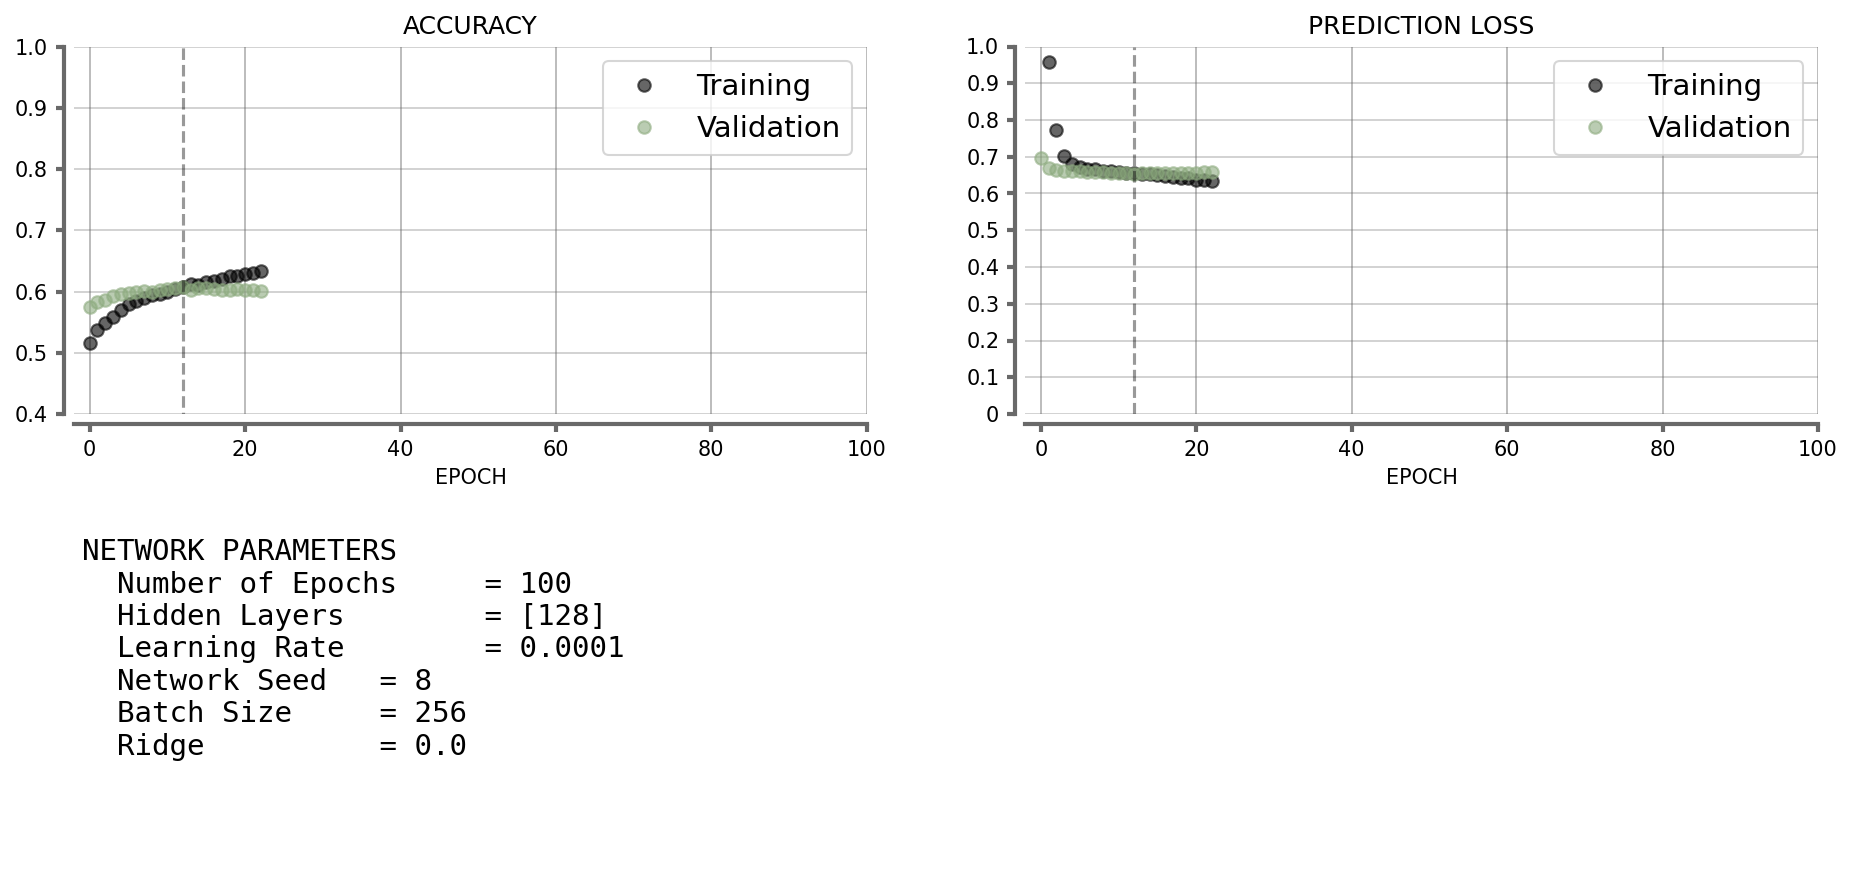

9
Epoch 1/1000
274/274 - 1s - loss: 1.5127 - sparse_categorical_accuracy: 0.5210 - val_loss: 0.7115 - val_sparse_categorical_accuracy: 0.5738 - 1s/epoch - 5ms/step
Epoch 2/1000
274/274 - 1s - loss: 1.0307 - sparse_categorical_accuracy: 0.5372 - val_loss: 0.6755 - val_sparse_categorical_accuracy: 0.5774 - 704ms/epoch - 3ms/step
Epoch 3/1000
274/274 - 1s - loss: 0.8044 - sparse_categorical_accuracy: 0.5445 - val_loss: 0.6661 - val_sparse_categorical_accuracy: 0.5857 - 573ms/epoch - 2ms/step
Epoch 4/1000
274/274 - 1s - loss: 0.7169 - sparse_categorical_accuracy: 0.5540 - val_loss: 0.6637 - val_sparse_categorical_accuracy: 0.5983 - 626ms/epoch - 2ms/step
Epoch 5/1000
274/274 - 1s - loss: 0.6846 - sparse_categorical_accuracy: 0.5686 - val_loss: 0.6624 - val_sparse_categorical_accuracy: 0.6014 - 630ms/epoch - 2ms/step
Epoch 6/1000
274/274 - 1s - loss: 0.6727 - sparse_categorical_accuracy: 0.5763 - val_loss: 0.6613 - val_sparse_categorical_accuracy: 0.6015 - 575ms/epoch - 2ms/step
Epoch 7/100

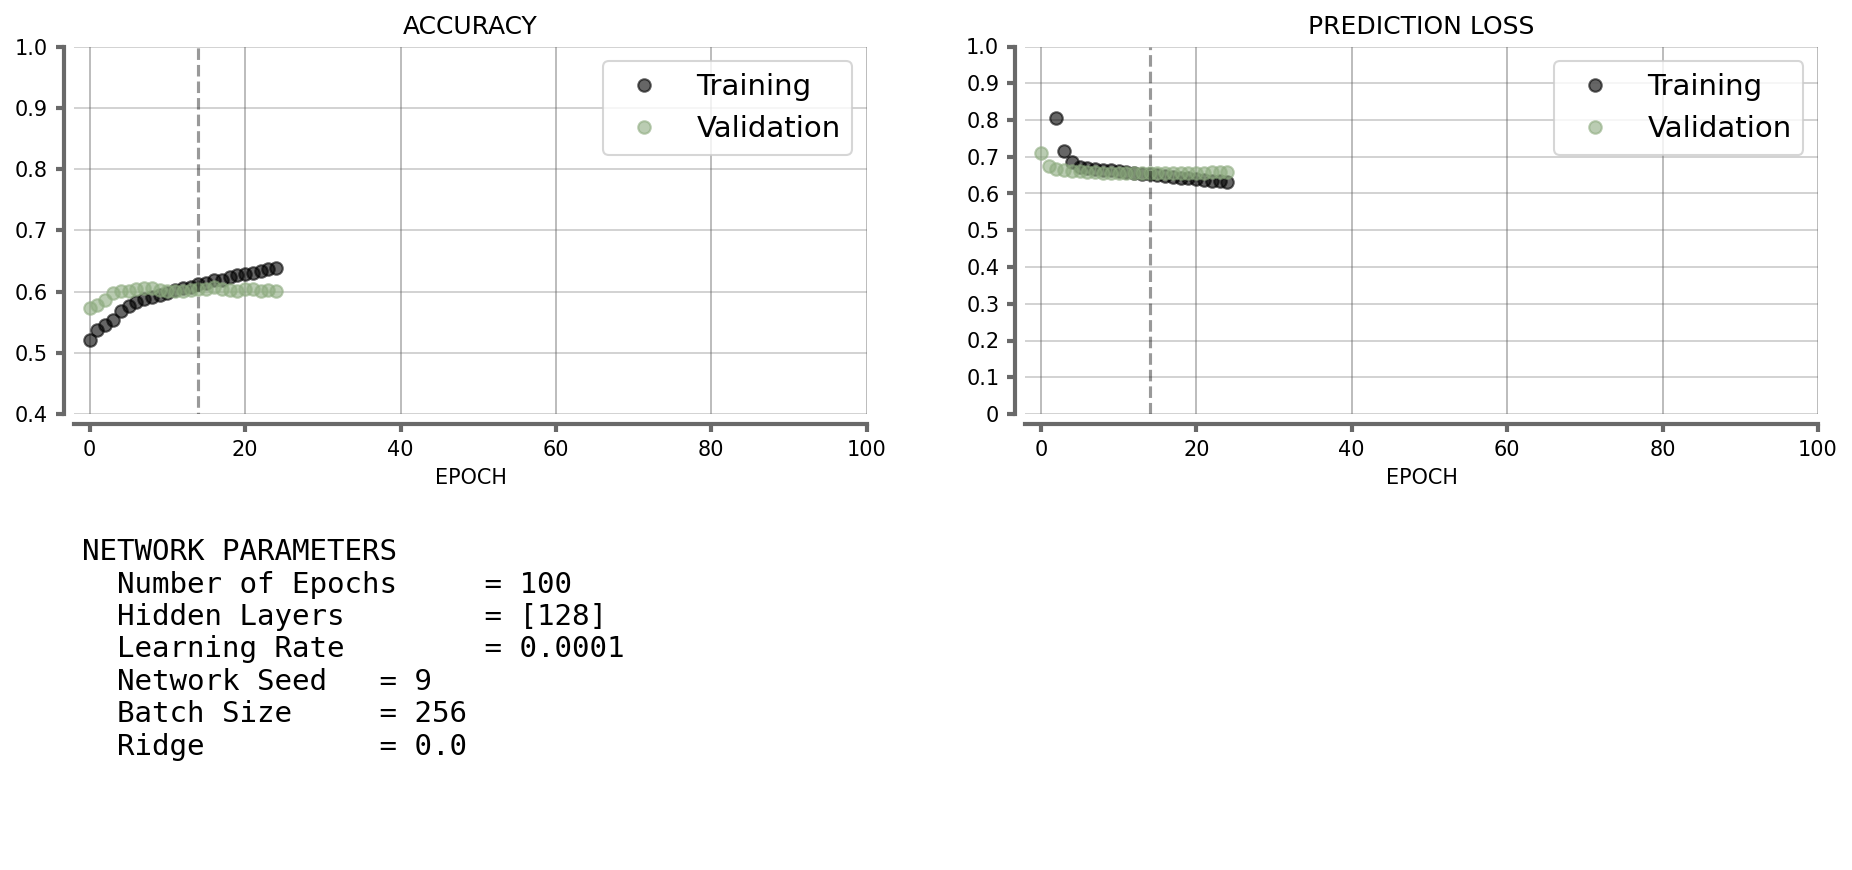

In [10]:
#----- SET UP & TRAIN NN -----
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

for SEED in np.arange(0,10):
    print(SEED)
    tf.keras.backend.clear_session() 

    # ------ define NN ------
    ann = create_ann(input_shape = input_shape,
                     n_output = 2,
                     hiddens=HIDDENS,
                     RIDGE = RIDGE,
                     dropout = dropout_bool, dropout_rate = dropout_rate)

    # ------ Training Hyperparameters ------
    optimizer = tf.optimizers.Adam(learning_rate = LR_INIT,)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name="sparse_categorical_accuracy", dtype=None)]                             

    # ------ Compile Model -----
    ann.compile(optimizer = optimizer,
                loss = loss_func,
                metrics = metrics)

    # ----- Callbacks -----
    ES = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'auto', min_delta = 0.001,
                                          patience = PATIENCE, verbose = 0, restore_best_weights = True)
    # LR = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)

    # ------ Train -----
    start_time = time.time()
    history = ann.fit(Xtrain,Ytrain,
                      validation_data = [Xval,Yval],
                      batch_size = BATCH_SIZE,
                      epochs = N_EPOCHS,
                      shuffle = True,
                      verbose = 2,
                      callbacks = [ES])#,LR])
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {(stop_time - start_time):.2f} seconds\n")
    
    #----- PLOT THE RESULTS -----
    plot_results(
        history,
        exp_info=(100, HIDDENS, LR_INIT, BATCH_SIZE, SEED, PATIENCE, RIDGE),
        showplot=True
    ) 
    
    annfi_name = 'ann1_e3sm_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    ann.save(base_dir+'train/saved_models/'+annfi_name)